# Topic Modeling on Scraped Breitbart Articles
## Timothy W. Dooley
## METIS Project 4

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

The `csv` imported below was scraped using `scrapebart.py` and merged with `merger.py`. Sentiment scoring was accomplished in `breit_transformer.py`.

In [81]:
df = pd.read_csv('breit31sents.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15675 entries, 0 to 15674
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15675 non-null  int64 
 1   dt          15675 non-null  object
 2   date        15675 non-null  object
 3   title       15675 non-null  object
 4   author      15675 non-null  object
 5   article     15675 non-null  object
 6   trunc_art   15671 non-null  object
 7   sentiment   15675 non-null  object
 8   sents       15675 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.1+ MB
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
df = df.drop(columns=['Unnamed: 0'])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import dtale

The following uses `spacy` tokenization. Eventually, this method was abandoned for typical `nltk` tokenization and vectorization.

In [6]:
nlp = spacy.load('en_core_web_sm')

In [22]:
df['spacy_doc'] = df.article.apply(lambda x: nlp(x))

In [ ]:
def rem_stops_spacy(column):
    no_sw = []
    for token in column:
        if token.is_stop == False:
            no_sw.append(token)
    no_sw = str(no_sw).strip().replace(',', '').replace('\xa0', '')
    return no_sw

In [ ]:
df['clean_spacy'] = df.spacy_doc.apply(rem_stops_spacy)

In [ ]:
alphanumeric = lambda x: re.sub("^[a-zA-Z0-9_]*$", '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
no_space = lambda x: x.strip()

df.clean_spacy = df.clean_spacy.map(alphanumeric).map(punc_lower).map(no_space)

In [ ]:
df.clean_spacy = df.clean_spacy.apply(lambda x: nlp(x))

In [ ]:
df.clean_spacy[5]

## Cleaning df.article
Articles are lowercased, stripped of punctuation and extraneous spaces, and non alphanumeric characters are removed. This process is mapped across all 15,000+ articles. 

In [16]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
no_space = lambda x: x.strip()

df['article'] = df.article.map(alphanumeric).map(punc_lower).map(no_space)
df.head()

dt         date  \
0  2020-11-10 07:08:14+00:00  10 Nov 2020   
1  2020-11-10 06:51:44+00:00  10 Nov 2020   
2  2020-11-10 06:18:25+00:00  10 Nov 2020   
3  2020-11-10 03:52:59+00:00  10 Nov 2020   
4  2020-11-10 02:59:14+00:00  10 Nov 2020   

                                               title           author  \
0  Bokhari on Tucker: Ruling Elites Allowed Big T...   Breitbart Tech   
1  ‘Loud Majority’ Rallies Power up as Trump Cont...  Dr. Susan Berry   
2  Republicans in Pennsylvania Call for Legislatu...   Joel B. Pollak   
3  Khan Says ‘It’s Never Been More Hard to Be a M...  Jack Montgomery   
4  RNC’s Shawn Steel: Republicans Beat Ballot Har...  Robert Kraychik   

                                             article  
0  breitbart news senior technology correspondent...  
1  the founder of a long island caravan rally in ...  
2  republican members of the pennsylvania house o...  
3  sadiq khan  the left wing mayor of london  had...  
4  shawn steel  rnc california national committee...

## Vectorization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
from sklearn.feature_extraction import text 

more_words = ['said', 'people', 'think', 'going', 'know']
stop_words = text.ENGLISH_STOP_WORDS.union(more_words)

### Stopwords
The following additional stopwords were added based on initial data exploration. Many words were generic or generically political and did not serve to create useful models. 

In [84]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop_ws = stop + ['election', 'percent', 'said', 'think', 'going', 'know', 'want', 'like', 'just', 'really', 'say', 'got', 'thing', 'let',\
    'get', 'would', 'mayor', 'sen', 'breitbart', 'com', 'org', 'get', 'rep', 'should', 'things', 'saying', 'told', 'also', 'pic', 'says', 'also', 'knows', 'knowing', 'tells', 'many', 'every', 'year', 'one', 'new', 'likely']

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df['no_sw'] = df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [85]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop_ws,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.8, 
                                min_df = 0.01)
dtm_tf = tf_vectorizer.fit_transform(df.article)
print(dtm_tf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(15675, 3082)


In [86]:
column_names = tf_vectorizer.get_feature_names()
vectors = pd.DataFrame.sparse.from_spmatrix(dtm_tf)
vectors.columns=column_names
vectors

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aaron  abc  ability  able  abortion  abortions  abrams  abroad  \
0          0    0        0     0         0          0       0       0   
1          0    0        0     0         0          0       0       0   
2          0    0        0     0         0          0       0       0   
3          0    0        0     0         0          0       0       0   
4          0    0        0     0         0          0       0       0   
...      ...  ...      ...   ...       ...        ...     ...     ...   
15670      0    0        0     0         0          0       0       0   
15671      0    0        0     0         0          0       0       0   
15672      0    0        0     0         0          0       0       0   
15673      0    0        0     0         0          0       0       0   
15674      0    0        0     0         0          0       0       0   

       absentee  absolutely  ...  years  yes  yesterday  yet  york  young  \
0             0           0  ...      0    0          0    0     0      0   
1             0           0  ...      0    0          0    1     0      0   
2             0           0  ...      1    0          0    0     0      0   
3             0           0  ...      0    1          0    0     0      0   
4             0           0  ...      0    0          0    0     0      0   
...         ...         ...  ...    ...  ...        ...  ...   ...    ...   
15670         0           0  ...      1    0          0    1     0      0   
15671         0           0  ...      0    0          0    1     0      0   
15672         0           0  ...      2    0          0    2     1      0   
15673         0           0  ...      3    0          0    1     0      0   
15674         0           0  ...      0    0          0    0     1      0   

       younger  youtube  zelensky  zero  
0            0        0         0     0  
1            0        0         0     0  
2            0        0         0     0  
3            0        0         0     0  
4            0        0         0     0  
...        ...      ...       ...   ...  
15670        0        0         0     0  
15671        0        0         0     0  
15672        0        0         0     0  
15673        0        0         0     0  
15674        0        0         0     0  

[15675 rows x 3082 columns]

In [87]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df.article)
print(dtm_tfidf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(15675, 3082)


By putting the vectorizer into a df we can examine the doc-word matrix. 

In [88]:
column_names = tfidf_vectorizer.get_feature_names()
vectorsidf = pd.DataFrame.sparse.from_spmatrix(dtm_tfidf)
vectorsidf.columns=column_names
vectorsidf

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aaron  abc  ability  able  abortion  abortions  abrams  abroad  \
0        0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
1        0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
2        0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
3        0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
4        0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
...      ...  ...      ...   ...       ...        ...     ...     ...   
15670    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
15671    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
15672    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
15673    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   
15674    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0   

       absentee  absolutely  ...     years       yes  yesterday       yet  \
0           0.0         0.0  ...  0.000000  0.000000        0.0  0.000000   
1           0.0         0.0  ...  0.000000  0.000000        0.0  0.027863   
2           0.0         0.0  ...  0.015735  0.000000        0.0  0.000000   
3           0.0         0.0  ...  0.000000  0.055791        0.0  0.000000   
4           0.0         0.0  ...  0.000000  0.000000        0.0  0.000000   
...         ...         ...  ...       ...       ...        ...       ...   
15670       0.0         0.0  ...  0.025423  0.000000        0.0  0.033887   
15671       0.0         0.0  ...  0.000000  0.000000        0.0  0.067038   
15672       0.0         0.0  ...  0.048024  0.000000        0.0  0.064013   
15673       0.0         0.0  ...  0.124818  0.000000        0.0  0.055458   
15674       0.0         0.0  ...  0.000000  0.000000        0.0  0.000000   

           york  young  younger  youtube  zelensky  zero  
0      0.000000    0.0      0.0      0.0       0.0   0.0  
1      0.000000    0.0      0.0      0.0       0.0   0.0  
2      0.000000    0.0      0.0      0.0       0.0   0.0  
3      0.000000    0.0      0.0      0.0       0.0   0.0  
4      0.000000    0.0      0.0      0.0       0.0   0.0  
...         ...    ...      ...      ...       ...   ...  
15670  0.000000    0.0      0.0      0.0       0.0   0.0  
15671  0.000000    0.0      0.0      0.0       0.0   0.0  
15672  0.027102    0.0      0.0      0.0       0.0   0.0  
15673  0.000000    0.0      0.0      0.0       0.0   0.0  
15674  0.038565    0.0      0.0      0.0       0.0   0.0  

[15675 rows x 3082 columns]

## K-Means
While K-means was tried, it did not make it into my final model. The topics modeled with NMF were sufficient. 

In [23]:
from sklearn.cluster import KMeans

In [24]:
X = dtm_tf

In [25]:
inertias = []

for k_ in np.arange(1, 10):
    km = KMeans(n_clusters=k_)
    km.fit(X)
    inertias.append(km.inertia_)
inertias

[9950667.011084883,
 9355235.13045329,
 9042478.56679824,
 8857118.165542142,
 8710878.9978613,
 8604904.007190133,
 8486151.861170609,
 8439871.447619915,
 8351004.469656437]

No handles with labels found to put in legend.


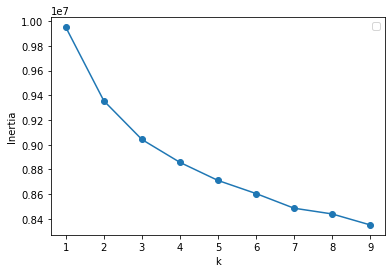

In [27]:
plt.plot(np.arange(1, 10), inertias, marker='o')
#plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

In [28]:
km = KMeans(n_clusters= 7)
km.fit(X)

KMeans(n_clusters=7)

## Latent Dirichlet Allocation
The first couple of versions of this model relied on LDA. The dimension reduction (LDA) on the vectorization provided by TF-IDF yielded some interesting topics. These are especially apparent went TSNE multidimensional scaling is employed (the last viz below). 
However, NMF was chosen for this dataset due to its clearer and more coherent topics. 

In [37]:
from sklearn.decomposition import LatentDirichletAllocation

In [89]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(random_state=0)

In [39]:
lda_tfidf

LatentDirichletAllocation(random_state=0)

In [40]:
import pyLDAvis
import pyLDAvis.sklearn

In [41]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds = 'mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.031177  0.129254       1        1  14.873043
1     -0.090263 -0.013046       2        1  14.108316
2     -0.061934 -0.161124       3        1  11.381045
3      0.131588  0.201958       4        1   9.197059
4      0.043135 -0.218162       5        1   9.151957
9     -0.184267  0.170333       6        1   9.146902
5      0.049449 -0.027723       7        1   9.025285
8     -0.198112 -0.031064       8        1   8.852069
0      0.181422 -0.098172       9        1   7.360886
7      0.160159  0.047747      10        1   6.903439, topic_info=           Term          Freq         Total Category  logprob  loglift
307       biden  45693.000000  45693.000000  Default  30.0000  30.0000
2845      trump  59486.000000  59486.000000  Default  29.0000  29.0000
388    campaign  16510.000000  16510.000000  Default  28.0000  28.0000
1476        joe  15112.000000  15112.000000  Default  27.0000  27.0000
2960     voters  10314.000000  10314.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
395   candidate    814.180267   7041.524736  Topic10  -5.5853   0.5158
2055  political    817.225460   7446.547411  Topic10  -5.5816   0.4636
2116    primary    782.764148   5058.219066  Topic10  -5.6247   0.8072
1550       last    803.686425   7600.121808  Topic10  -5.5983   0.4264
1089      first    782.435307   8968.802836  Topic10  -5.6251   0.2341

[645 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.043344  abortion
4         3  0.834701  abortion
4         4  0.106430  abortion
4         7  0.000858  abortion
4         8  0.014162  abortion
...     ...       ...       ...
3067      8  0.024281      york
3067      9  0.100237      york
3067     10  0.175571      york
3071      3  0.935667  zelensky
3071      5  0.062783  zelensky

[3433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 3, 4, 5, 10, 6, 9, 1, 8])

In [42]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds ='mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.003757  0.040090       1        1  33.162218
2     -0.050509 -0.027660       2        1  13.425290
6     -0.008442  0.073017       3        1  13.039228
3      0.073542 -0.026107       4        1  11.092674
9      0.052398  0.063398       5        1   9.142358
8      0.198630  0.102249       6        1   8.662911
7      0.046872  0.250138       7        1   3.900629
5      0.167794 -0.286399       8        1   2.677597
0     -0.332436  0.050953       9        1   2.585095
4     -0.144092 -0.239679      10        1   2.312001, topic_info=           Term        Freq       Total Category  logprob  loglift
307       biden  991.000000  991.000000  Default  30.0000  30.0000
2052     police  191.000000  191.000000  Default  29.0000  29.0000
1335     hunter  173.000000  173.000000  Default  28.0000  28.0000
466       china  188.000000  188.000000  Default  27.0000  27.0000
1662       mail  177.000000  177.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2559     social   23.730685  121.249246  Topic10  -4.8779   2.1360
309         big   23.766755  124.529020  Topic10  -4.8764   2.1108
2055  political   22.495690  207.351343  Topic10  -4.9314   1.5460
1837       news   23.457605  366.262444  Topic10  -4.8895   1.0189
2595     speech   18.350355  123.112190  Topic10  -5.1350   1.8636

[586 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.032336  abortion
4         2  0.021557  abortion
4         3  0.873078  abortion
4         4  0.021557  abortion
4         5  0.032336  abortion
...     ...       ...       ...
3061      3  0.435129      yang
3061      4  0.048348      yang
3061      6  0.483477      yang
3071      1  0.037515  zelensky
3071      2  0.937873  zelensky

[2684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 7, 4, 10, 9, 8, 6, 1, 5])

In [43]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds = 'tsne')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  14.873043
1       0.648955  71.707100       2        1  14.108316
2      71.019684   9.971006       3        1  11.381045
3       3.785981  33.185135       4        1   9.197059
4     -42.666500  -9.222070       5        1   9.151957
9      -3.621689 -43.526516       6        1   9.146902
5      -3.632402  -4.171708       7        1   9.025285
8     -36.584400  35.804413       8        1   8.852069
0      44.391380  50.615383       9        1   7.360886
7      40.235809 -31.591665      10        1   6.903439, topic_info=           Term          Freq         Total Category  logprob  loglift
307       biden  45693.000000  45693.000000  Default  30.0000  30.0000
2845      trump  59486.000000  59486.000000  Default  29.0000  29.0000
388    campaign  16510.000000  16510.000000  Default  28.0000  28.0000
1476        joe  15112.000000  15112.000000  Default  27.0000  27.0000
2960     voters  10314.000000  10314.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
395   candidate    814.180267   7041.524736  Topic10  -5.5853   0.5158
2055  political    817.225460   7446.547411  Topic10  -5.5816   0.4636
2116    primary    782.764148   5058.219066  Topic10  -5.6247   0.8072
1550       last    803.686425   7600.121808  Topic10  -5.5983   0.4264
1089      first    782.435307   8968.802836  Topic10  -5.6251   0.2341

[645 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.043344  abortion
4         3  0.834701  abortion
4         4  0.106430  abortion
4         7  0.000858  abortion
4         8  0.014162  abortion
...     ...       ...       ...
3067      8  0.024281      york
3067      9  0.100237      york
3067     10  0.175571      york
3071      3  0.935667  zelensky
3071      5  0.062783  zelensky

[3433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 3, 4, 5, 10, 6, 9, 1, 8])

In [45]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds ='tsne')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  33.162218
2       0.648955  71.707100       2        1  13.425290
6      71.019684   9.971006       3        1  13.039228
3       3.785981  33.185135       4        1  11.092674
9     -42.666500  -9.222070       5        1   9.142358
8      -3.621689 -43.526516       6        1   8.662911
7      -3.632402  -4.171708       7        1   3.900629
5     -36.584400  35.804413       8        1   2.677597
0      44.391380  50.615383       9        1   2.585095
4      40.235809 -31.591665      10        1   2.312001, topic_info=           Term        Freq       Total Category  logprob  loglift
307       biden  991.000000  991.000000  Default  30.0000  30.0000
2052     police  191.000000  191.000000  Default  29.0000  29.0000
1335     hunter  173.000000  173.000000  Default  28.0000  28.0000
466       china  188.000000  188.000000  Default  27.0000  27.0000
1662       mail  177.000000  177.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2559     social   23.730685  121.249246  Topic10  -4.8779   2.1360
309         big   23.766755  124.529020  Topic10  -4.8764   2.1108
2055  political   22.495690  207.351343  Topic10  -4.9314   1.5460
1837       news   23.457605  366.262444  Topic10  -4.8895   1.0189
2595     speech   18.350355  123.112190  Topic10  -5.1350   1.8636

[586 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.032336  abortion
4         2  0.021557  abortion
4         3  0.873078  abortion
4         4  0.021557  abortion
4         5  0.032336  abortion
...     ...       ...       ...
3061      3  0.435129      yang
3061      4  0.048348      yang
3061      6  0.483477      yang
3071      1  0.037515  zelensky
3071      2  0.937873  zelensky

[2684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 7, 4, 10, 9, 8, 6, 1, 5])

## Word2Vec with gensim
This w2v model provided some interesting analogies and word associations. Eventually I felt that this method relied to heavily on my own biases in the creation of analogies. It was instructive to recognize how Breitbart considers some topics, but I wanted to have a slightly less biased method (on my direct intervention) to build a similar study. As such, I built `BreitBot` using GPT-2 and hosted that model on Hugging Face. A link to `BreitBot` is found in the README of this repo. 

In [46]:
import gensim

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [47]:
# Tokenize the documents
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in df.article]

# Create a Gensim Dictionary.  This creates an id to word mapping for everything in our vocbulary
# It is NOT the same as the dictionary object in the Python standard library
mydict = gensim.corpora.Dictionary()

# Create a Gensim Corpus object.  This creates a list of tuples for each document.
# The first element of the tuple is the word id, the second is the number of counts
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_docs]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# sg means that we are using the Skip-gram architecture

model = gensim.models.Word2Vec(tokenized_docs, sg=1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
model.most_similar('cnn' ,topn=25)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-b78b09b45ce3>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('cnn' ,topn=25)


[('abc', 0.7276099920272827),
 ('cnnnewsroom', 0.7275697588920593),
 ('outfront', 0.7078627943992615),
 ('anderson', 0.6959517002105713),
 ('anchors', 0.689020037651062),
 ('msnbc', 0.6847326755523682),
 ('velshi', 0.6812652945518494),
 ('nbc', 0.6760221719741821),
 ('tapper', 0.6755555868148804),
 ('danabashcnn', 0.6753721833229065),
 ('bash', 0.6706513166427612),
 ('unhsurveycenter', 0.6696527004241943),
 ('jake', 0.6690244674682617),
 ('univision', 0.6678110957145691),
 ('broadcasted', 0.6636104583740234),
 ('fox', 0.6629199981689453),
 ('wnep', 0.6626611351966858),
 ('cillizzacnn', 0.6584850549697876),
 ('pbs', 0.657927930355072),
 ('hardball', 0.6574313640594482),
 ('lemon', 0.6564469337463379),
 ('brianna', 0.6554713845252991),
 ('cnnpolitics', 0.6554069519042969),
 ('newshour', 0.6524739265441895),
 ('nbcnightlynews', 0.6508199572563171)]

In [51]:
model.most_similar(positive=['arabs', 'police'], negative=['good'])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-530c07d7c3ba>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['arabs', 'police'], negative=['good'])


[('hamas', 0.6300586462020874),
 ('militants', 0.6213947534561157),
 ('civilians', 0.6128972172737122),
 ('demonstrations', 0.6059727668762207),
 ('violent', 0.5958265066146851),
 ('synagogues', 0.5946581363677979),
 ('officers', 0.5929319262504578),
 ('assaults', 0.5929250717163086),
 ('disband', 0.5890277624130249),
 ('shia', 0.588334858417511)]

In [52]:
model.most_similar(positive=['pelosi', 'trump'], negative=['support'])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-52-5cc1958beb83>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['pelosi', 'trump'], negative=['support'])


[('nancy', 0.6263524293899536),
 ('donald', 0.5944786667823792),
 ('mcenany', 0.584703803062439),
 ('speaker', 0.5801249742507935),
 ('kellyanne', 0.5799732208251953),
 ('purpura', 0.5710890293121338),
 ('speakerpelosi', 0.5600984692573547),
 ('shifty', 0.5575753450393677),
 ('kayleigh', 0.5567646622657776),
 ('schiff', 0.542728066444397)]

In [ ]:
words = list(model.wv.vocab)

## Dimensionality Reduction with PCA and SVD
As with LDA, these methods were employed in an attempt to reduce dimensionality and produce coherent models. Again, NMF was chosen for its coherent topics. 

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD

In [192]:
pca = PCA(n_components=2)
svd = TruncatedSVD(5)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
result = svd.fit(dtm_tf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [194]:
sum(result.explained_variance_ratio_)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2321234210644882

In [90]:
import matplotlib.pyplot as plt

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [195]:
result_fit = result.transform(dtm_tf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


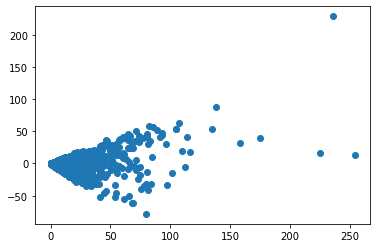

In [196]:
plt.scatter(result_fit[:, 0], result_fit[:, 1])
#words = list(model.wv.vocab)
#for i, word in enumerate(words):
#	plt.annotate(word, xy=(result[i, 0], result[i, 1]))

The following function maps words to the topics created by the dimensionality reduction techniques to better aid in the creation of topic names. 

In [51]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    This function enumerates components (words in model) of each DR model. 
    This aids in the building of models by allowing the model maker to consider the components of the reduction. 
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [198]:
display_topics(svd, tf_vectorizer.get_feature_names(), 50)


Topic  0
trump, biden, president, people, twitter, democrats, one, news, campaign, joe, new, former, donald, american, house, state, country, sanders, democrat, voters, time, vote, america, first, presidential, vice, even, states, white, party, obama, support, years, left, back, americans, political, last, impeachment, two, november, harris, media, make, could, debate, democratic, october, black, national

Topic  1
trump, rally, supporter, november, october, supporters, donald, maga, twitter, impeachment, realdonaldtrump, crowd, september, june, gop, july, man, sign, republican, images, great, february, anti, august, january, wearing, pelosi, pennsylvania, signs, house, minnesota, attacked, north, republicans, outside, schiff, watch, protesters, america, pro, flag, arrested, antifa, democrats, talks, pence, mueller, woman, fake, russia

Topic  2
biden, trump, joe, hunter, vice, rally, china, supporter, september, wallace, son, burisma, october, reade, talks, crowd, maga, schweizer, cl

In [266]:
H = pd.DataFrame(result_fit.round(5),
             columns = ["2020","trump_rally", "hunter", "impeach_russia", "vote"])
H

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2020  trump_rally   hunter  impeach_russia     vote
0       3.67512     -1.01717 -3.18104         3.01604 -0.54560
1      12.18026      1.45346  1.28242        -1.44736  3.85879
2      21.61048      4.07376 -6.82249        -1.53496 -1.55014
3       5.58940      1.01966 -0.17973         0.22826 -0.68216
4       6.18528      1.45158 -2.31864         0.31875  1.45937
...         ...          ...      ...             ...      ...
15244  12.98354    -10.61158  4.48534         2.48946  0.02442
15245   4.72560      2.14769 -1.29578         0.37319 -0.42904
15246  15.94457    -14.34746  0.54939         1.33735  0.04449
15247   8.48764     -6.64668  1.73711         2.18183  0.65684
15248   8.02207     -3.63306 -6.53238        -0.41173  0.41432

[15249 rows x 5 columns]

## Non-Negative Matrix Factorization
The chosen model for this project. It created ten coherent topics with little significant overlap (as was an issue in many of the above attempts). TF-IDF vectorization was also chosen. 

In [94]:
from sklearn.decomposition import NMF


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
doc_word = tfidf_vectorizer.fit_transform(df.article)
pd.DataFrame(doc_word.toarray(), columns=tfidf_vectorizer.get_feature_names()).head(10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aaron  abc  ability  able  abortion  abortions  abrams  abroad  absentee  \
0    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
1    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
2    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
3    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
4    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
5    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
6    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
7    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
8    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   
9    0.0  0.0      0.0   0.0       0.0        0.0     0.0     0.0       0.0   

   absolutely  ...     years       yes  yesterday       yet      york  young  \
0    0.000000  ...  0.000000  0.000000   0.000000  0.000000  0.000000    0.0   
1    0.000000  ...  0.000000  0.000000   0.000000  0.027863  0.000000    0.0   
2    0.000000  ...  0.015735  0.000000   0.000000  0.000000  0.000000    0.0   
3    0.000000  ...  0.000000  0.055791   0.000000  0.000000  0.000000    0.0   
4    0.000000  ...  0.000000  0.000000   0.000000  0.000000  0.000000    0.0   
5    0.000000  ...  0.000000  0.000000   0.137259  0.000000  0.000000    0.0   
6    0.000000  ...  0.000000  0.000000   0.000000  0.000000  0.000000    0.0   
7    0.039319  ...  0.000000  0.036210   0.000000  0.000000  0.076211    0.0   
8    0.000000  ...  0.000000  0.000000   0.000000  0.000000  0.000000    0.0   
9    0.000000  ...  0.000000  0.152616   0.000000  0.126446  0.000000    0.0   

   younger  youtube  zelensky  zero  
0      0.0      0.0       0.0   0.0  
1      0.0      0.0       0.0   0.0  
2      0.0      0.0       0.0   0.0  
3      0.0      0.0       0.0   0.0  
4      0.0      0.0       0.0   0.0  
5      0.0      0.0       0.0   0.0  
6      0.0      0.0       0.0   0.0  
7      0.0      0.0       0.0   0.0  
8      0.0      0.0       0.0   0.0  
9      0.0      0.0       0.0   0.0  

[10 rows x 3082 columns]

In [95]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5", "component_6","component_7", "component_8", "component_9", "component_10"],
             columns = tf_vectorizer.get_feature_names())
topic_word

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aaron    abc  ability   able  abortion  abortions  abrams  \
component_1   0.007  0.078    0.063  0.200     0.423      0.077   0.097   
component_2   0.000  0.023    0.010  0.002     0.000      0.000   0.000   
component_3   0.000  0.033    0.022  0.035     0.000      0.000   0.010   
component_4   0.009  0.000    0.022  0.056     0.000      0.000   0.085   
component_5   0.012  0.026    0.000  0.000     0.000      0.000   0.000   
component_6   0.001  0.007    0.016  0.030     0.000      0.000   0.000   
component_7   0.000  0.000    0.021  0.051     0.011      0.014   0.000   
component_8   0.000  0.008    0.030  0.011     0.048      0.008   0.006   
component_9   0.023  0.043    0.025  0.010     0.000      0.000   0.000   
component_10  0.008  0.019    0.000  0.000     0.045      0.009   0.000   

              abroad  absentee  absolutely  ...  years    yes  yesterday  \
component_1    0.012     0.000       0.107  ...  0.318  0.177      0.042   
component_2    0.001     0.000       0.005  ...  0.011  0.007      0.003   
component_3    0.003     0.000       0.004  ...  0.064  0.006      0.001   
component_4    0.000     0.456       0.024  ...  0.012  0.000      0.013   
component_5    0.005     0.000       0.005  ...  0.137  0.000      0.020   
component_6    0.000     0.000       0.023  ...  0.015  0.022      0.017   
component_7    0.017     0.000       0.005  ...  0.163  0.011      0.000   
component_8    0.000     0.000       0.000  ...  0.000  0.032      0.000   
component_9    0.009     0.000       0.009  ...  0.013  0.002      0.017   
component_10   0.003     0.000       0.004  ...  0.041  0.004      0.005   

                yet   york  young  younger  youtube  zelensky   zero  
component_1   0.155  0.209  0.207    0.001    0.039     0.000  0.030  
component_2   0.036  0.101  0.020    0.021    0.000     0.000  0.013  
component_3   0.012  0.000  0.001    0.026    0.045     0.000  0.002  
component_4   0.021  0.050  0.019    0.004    0.027     0.000  0.001  
component_5   0.017  0.035  0.002    0.000    0.014     0.000  0.007  
component_6   0.053  0.010  0.000    0.000    0.000     0.141  0.006  
component_7   0.028  0.045  0.045    0.004    0.000     0.000  0.030  
component_8   0.028  0.007  0.000    0.000    0.000     0.000  0.013  
component_9   0.030  0.199  0.000    0.088    0.019     0.107  0.013  
component_10  0.038  0.079  0.000    0.000    0.007     0.000  0.010  

[10 rows x 3082 columns]

The following topics are coherent and demonstrate little overlap. 

In [99]:
display_topics(nmf_model, tfidf_vectorizer.get_feature_names(), 10)


Topic  0
people, black, right, country, women, twitter, america, party, police, white

Topic  1
sanders, warren, bernie, buttigieg, poll, bloomberg, support, elizabeth, iowa, campaign

Topic  2
biden, joe, vice, former, president, obama, reade, campaign, presidential, nominee

Topic  3
mail, ballots, vote, voting, voters, voter, ballot, state, absentee, fraud

Topic  4
trump, president, rally, donald, campaign, supporters, coronavirus, october, crowd, realdonaldtrump

Topic  5
impeachment, house, democrats, pelosi, senate, inquiry, president, congressional, schiff, committee

Topic  6
immigration, illegal, workers, aliens, american, jobs, foreign, million, americans, border

Topic  7
harris, kamala, debate, california, gabbard, pence, presidential, campaign, mate, vice

Topic  8
hunter, china, burisma, ukraine, son, company, ukrainian, chinese, schweizer, corruption

Topic  9
court, supreme, sunday, news, barrett, pollak, joel, joelpollak, book, alumni
/opt/anaconda3/envs/metis/lib/py

1. BLM/Race/Identity Politics/Police
2. DNC Bogetmen of Sanders, Warren, Buttigieg (and Bloomberg)
3. Joe Biden (note the negative association with the Reade scandal)
4. Mail Voting and "Fraud"
5. Trump. (note the positive association with rallies, supporters. Note also that Covid is a sub-topic of Trump)
6. Impeachment
7. Immigration
8. Kamala Harris
9. Hunter Biden, Burisma, Ukraine (Breitbart's October Surprise)
10. SCOTUS and Amy Coney Barrett 


In [100]:
nmf_index = ["race_police", "sand_warr_butti", "biden", "mail_vote", "trump", "impeach", "immi", "harris", "hunter", "scotus"]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
Hlda = pd.DataFrame(lda_tfidf.fit_transform(dtm_tfidf).round(5),
             columns = ["police_antifa","biden", "impeach", "immigration_covid", "tech", "hunter", "sanders_warren_climate", "mail_vote", "dems", "trump"])
Hlda

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


police_antifa    biden  impeach  immigration_covid     tech   hunter  \
0            0.90636  0.01040  0.01040            0.01041  0.01041  0.01041   
1            0.86927  0.01453  0.01452            0.01453  0.01453  0.01453   
2            0.89582  0.01158  0.01158            0.01158  0.01158  0.01158   
3            0.90344  0.01073  0.01073            0.01073  0.01073  0.01073   
4            0.01400  0.01400  0.01398            0.01399  0.01400  0.01400   
...              ...      ...      ...                ...      ...      ...   
15670        0.92712  0.00810  0.00810            0.00810  0.00810  0.00810   
15671        0.53420  0.01377  0.01376            0.01378  0.35566  0.01377   
15672        0.93888  0.00679  0.00679            0.00679  0.00679  0.00679   
15673        0.27461  0.65403  0.00892            0.00892  0.00892  0.00892   
15674        0.00774  0.93032  0.00774            0.00775  0.00774  0.00774   

       sanders_warren_climate  mail_vote     dems    trump  
0                     0.01040    0.01040  0.01040  0.01041  
1                     0.01453    0.01452  0.01452  0.01453  
2                     0.01158    0.01157  0.01157  0.01158  
3                     0.01073    0.01073  0.01073  0.01073  
4                     0.01399    0.01399  0.01398  0.87407  
...                       ...        ...      ...      ...  
15670                 0.00810    0.00811  0.00810  0.00810  
15671                 0.01377    0.01376  0.01376  0.01377  
15672                 0.00679    0.00680  0.00679  0.00679  
15673                 0.00892    0.00893  0.00892  0.00892  
15674                 0.00774    0.00774  0.00774  0.00774  

[15675 rows x 10 columns]

In [61]:
Hlda['lda_label'] = Hlda.idxmax(axis=1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
df['lda_label']= Hlda.lda_label

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
import seaborn as sns

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='lda_label', ylabel='count'>

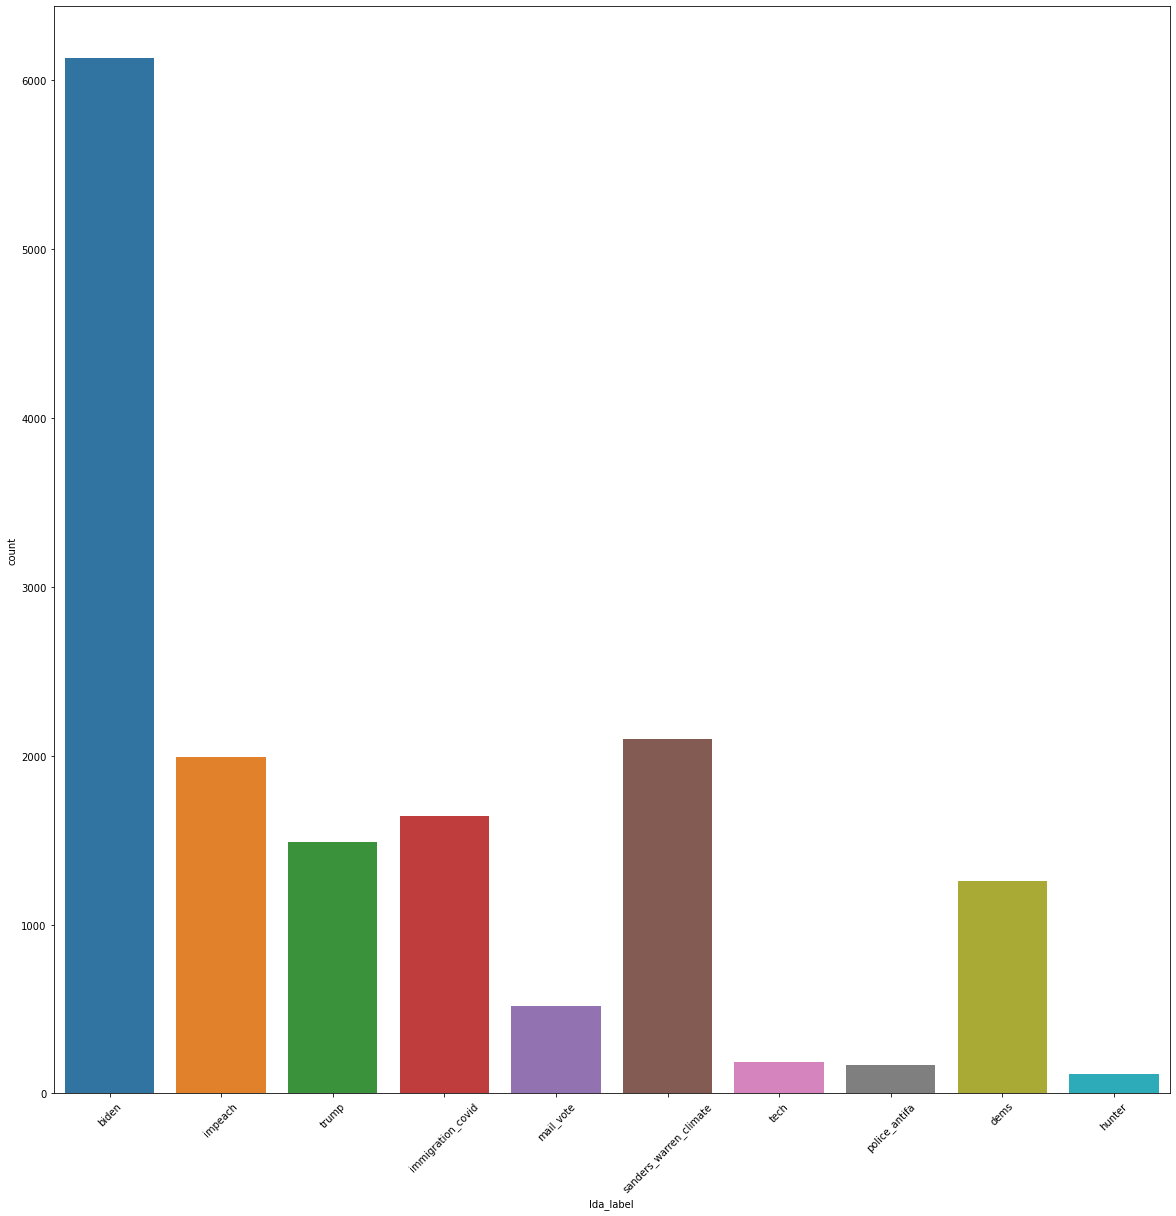

In [68]:
plt.figure(figsize=(20,20))
plt.xticks(rotation = 45)
sns.countplot("lda_label", data = df)

In [296]:
display_topics(nmf_model, tf_vectorizer.get_feature_names(), 10)


Topic  0
people, black, right, country, women, twitter, america, party, police, white

Topic  1
sanders, warren, bernie, buttigieg, poll, bloomberg, support, elizabeth, iowa, campaign

Topic  2
biden, joe, vice, former, president, obama, reade, campaign, presidential, nominee

Topic  3
mail, ballots, vote, voting, voters, voter, ballot, state, absentee, fraud

Topic  4
trump, president, rally, donald, campaign, supporters, coronavirus, october, crowd, realdonaldtrump

Topic  5
impeachment, house, democrats, pelosi, senate, inquiry, president, congressional, schiff, committee

Topic  6
immigration, illegal, workers, aliens, american, jobs, foreign, million, americans, border

Topic  7
harris, kamala, debate, california, gabbard, pence, presidential, campaign, mate, vice

Topic  8
hunter, china, burisma, ukraine, son, company, ukrainian, chinese, schweizer, corruption

Topic  9
court, supreme, sunday, news, barrett, pollak, joel, joelpollak, book, alumni
/opt/anaconda3/envs/metis/lib/py

In [101]:
H = pd.DataFrame(doc_topic.round(5),
             columns = nmf_index)
H

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


race_police  sand_warr_butti    biden  mail_vote    trump  impeach  \
0          0.01859          0.00000  0.02059    0.03849  0.04245  0.00150   
1          0.01231          0.00055  0.01674    0.00408  0.02994  0.00000   
2          0.01407          0.00000  0.02530    0.01346  0.04366  0.00000   
3          0.03366          0.00000  0.02410    0.00048  0.02011  0.00000   
4          0.00000          0.01798  0.09775    0.02911  0.05334  0.00000   
...            ...              ...      ...        ...      ...      ...   
15670      0.03908          0.00000  0.07641    0.00123  0.00444  0.00533   
15671      0.00639          0.00000  0.00000    0.00064  0.03070  0.01120   
15672      0.04026          0.03140  0.07964    0.00019  0.01139  0.00524   
15673      0.02877          0.00814  0.07622    0.00000  0.00797  0.00000   
15674      0.02748          0.05771  0.01192    0.00000  0.00000  0.03465   

          immi   harris   hunter   scotus  
0      0.01174  0.00035  0.01338  0.00000  
1      0.00000  0.00306  0.01217  0.02569  
2      0.00000  0.00204  0.00144  0.00692  
3      0.00988  0.00000  0.00172  0.00231  
4      0.00000  0.00000  0.00000  0.00461  
...        ...      ...      ...      ...  
15670  0.00000  0.00320  0.01038  0.00143  
15671  0.02928  0.00000  0.00000  0.02887  
15672  0.00000  0.00557  0.00924  0.00661  
15673  0.00000  0.00048  0.00000  0.04988  
15674  0.03403  0.00192  0.00246  0.01181  

[15675 rows x 10 columns]

In [245]:
df.iloc[1].article

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'stay tuned to breitbart news for live updates of the   presidential election  president donald trump and former vice presiden joe biden are battling over pennsylvania  north carolina  georgia  arizona  and nevada    all times eastern  —     am  georgia  cnn reporting there are around     ballots left to count       am  georgia   good thursday morning   as of     a m   about     votes separate trump and biden  today s absentee file isn t fully updated  so based on yesterday  there s still potentially   ballots left  before provisionals  cures  military overseas   fulton has    left   gapol pic twitter com   — stephen fowler covers georgia s election    stphnfwlr  november          am  georgia  results expected around   am   here’s our latest tally of how many absentee ballots remain – and where they are coming from   hint  most are concentrated in highly populated areas  led by fulton county in atlanta and chatham county in savannah    gapol https   t co   — greg bluestein   bluestein 

*Let's set our NMF Labels to the articles in the DataFrame*

In [102]:
H['nmf_label'] = H.idxmax(axis=1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
df['nmf_label']= H.nmf_label

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Plot the occurences of each topic as a total count. 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(500.0, 2864.4)

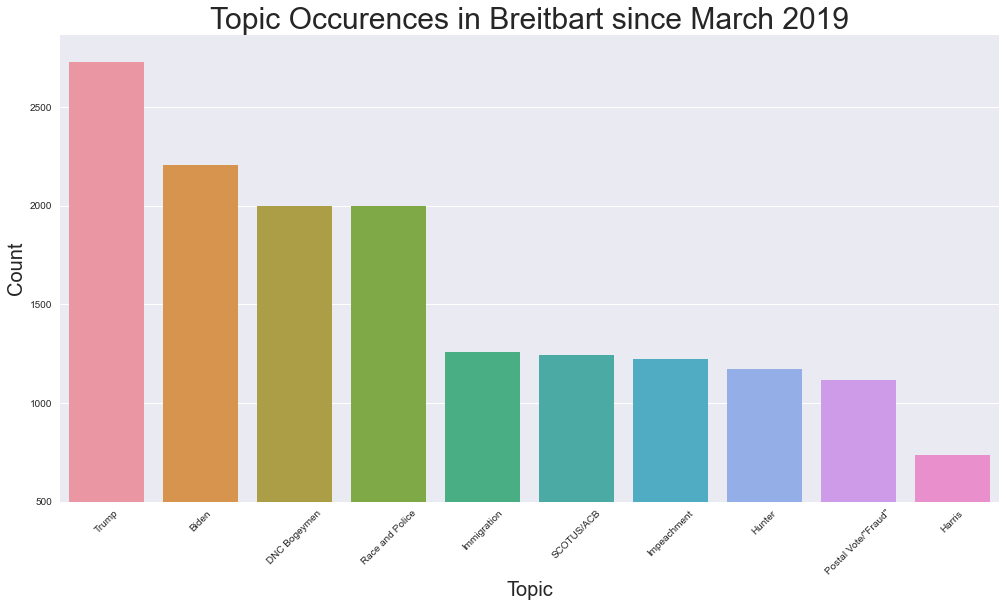

In [316]:
plt.figure(figsize = (15,8))
ax = sns.countplot('nmf_label', data = df, order = ['trump', 'biden', 'sand_warr_butti', 'race_police', 'immi', 'scotus', 'impeach', 'hunter', 'mail_vote', 'harris'])
ax.set_xticklabels(rotation = 45, labels=['Trump', 'Biden', 'DNC Bogeymen', 'Race and Police', 'Immigration', 'SCOTUS/ACB', 'Impeachment', 'Hunter', 'Postal Vote/"Fraud"', 'Harris'])
ax.set_xlabel('Topic', size = 20)
ax.set_ylabel('Count', size = 20)
ax.set_title('Topic Occurences in Breitbart since March 2019', size = 30)

ax.set_ylim(500)

### What are the sentiments of these topics? 

### Race and Police

In [112]:
df[df.nmf_label == 'race_police'].sents.value_counts(normalize = True)

Race and police, Sentiment: 
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NEGATIVE    0.705706
POSITIVE    0.294294
Name: sents, dtype: float64

### Trump

In [113]:
df[df.nmf_label == 'trump'].sents.value_counts(normalize = True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NEGATIVE    0.692082
POSITIVE    0.307918
Name: sents, dtype: float64

### Biden

In [114]:
df[df.nmf_label == 'biden'].sents.value_counts(normalize = True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NEGATIVE    0.776167
POSITIVE    0.223833
Name: sents, dtype: float64

### Hunter

In [115]:
df[df.nmf_label == 'hunter'].sents.value_counts(normalize = True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NEGATIVE    0.870418
POSITIVE    0.129582
Name: sents, dtype: float64

### Save the new NMF-labeled df as a csv.

In [122]:
df.to_csv('breit31sentsNMF.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [131]:
df['month_year'] = pd.to_datetime(df['dt']).dt.to_period('M')
df['neg'] = np.where(df.sents.str.contains('NEGATIVE'), 1, 0)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
sent_df = df[['sents', 'month_year']]
sent_df = sent_df.set_index('month_year')
sent_df = sent_df.groupby(pd.Grouper(freq='M')).count()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
neg_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


neg
month_year      
2019-03        1
2019-04      222
2019-05      253
2019-06      539
2019-07      552
2019-08      546
2019-09      587
2019-10      621
2019-11      464
2019-12      464
2020-01      536
2020-02      872
2020-03      496
2020-04      281
2020-05      436
2020-06      414
2020-07      469
2020-08      916
2020-09      930
2020-10     1549
2020-11      675

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x720 with 0 Axes>

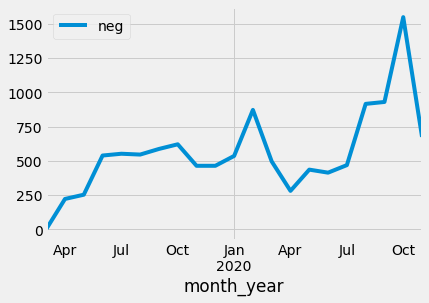

In [194]:
neg_df = df[['neg', 'month_year']]
neg_df = neg_df.set_index('month_year')
neg_df = neg_df.groupby(pd.Grouper(freq='M')).sum()
plt.figure(figsize=(15,10))

neg_df.reset_index().plot(x = 'month_year', y = 'neg')
plt.style.use('fivethirtyeight')
#plt.plot(neg_df)

In [176]:
percent = neg_df.neg/sent_df.sents
perneg_df = pd.DataFrame(percent, columns = ['percent'])
perneg_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


percent
month_year          
2019-03     0.333333
2019-04     0.711538
2019-05     0.724928
2019-06     0.741403
2019-07     0.752044
2019-08     0.772277
2019-09     0.787919
2019-10     0.772388
2019-11     0.765677
2019-12     0.756933
2020-01     0.754930
2020-02     0.749141
2020-03     0.739195
2020-04     0.733681
2020-05     0.797075
2020-06     0.782609
2020-07     0.755233
2020-08     0.701378
2020-09     0.766063
2020-10     0.769498
2020-11     0.736096

In [180]:
perneg_df = perneg_df[perneg_df.index > '2019-03']

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [407]:
perneg_df['pos'] = 1 - perneg_df.percent

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### How negative is Breitbart over time? 
Quite...
At least 70% of the articles per month are negative in sentiment. 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Percentage of Articles with Negative Sentiment by Month')

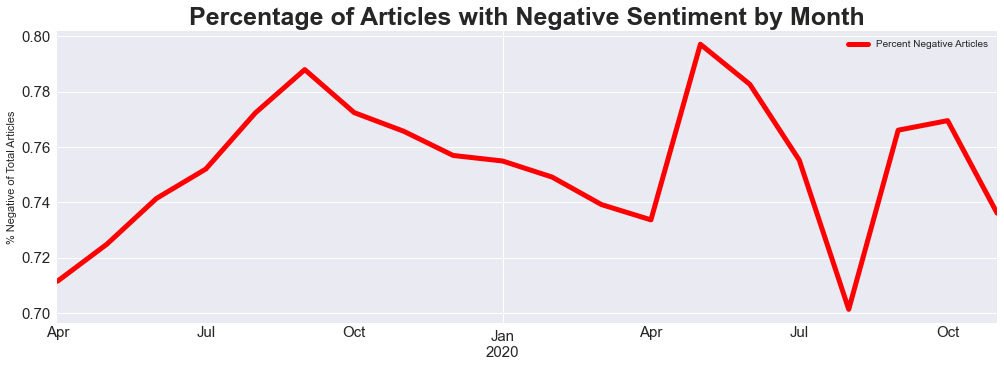

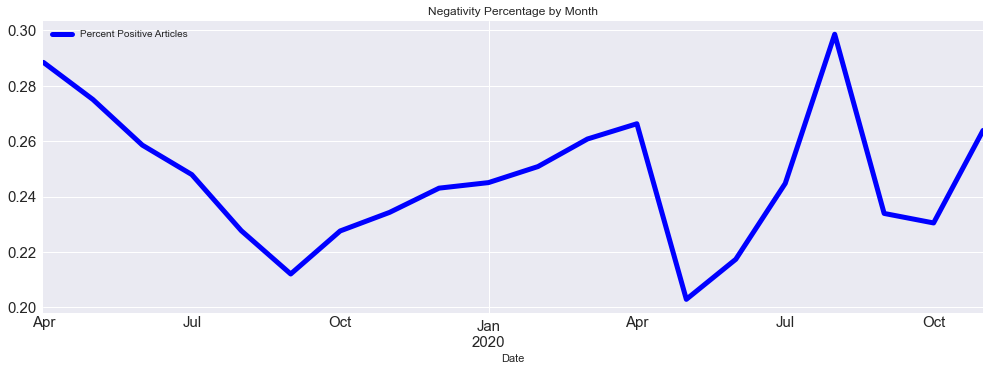

In [409]:

fig = perneg_df.reset_index().plot(x = 'month_year', y = "percent", figsize = (15,5), title = 'Negativity Percentage by Month', c = 'r', xlabel = 'Date', fontsize = 15, label = 'Percent Negative Articles', lw = 5)
fig2 = perneg_df.reset_index().plot(x = 'month_year', y = "pos", figsize = (15,5), title = 'Negativity Percentage by Month', c = 'blue', xlabel = 'Date', fontsize = 15, label = 'Percent Positive Articles', lw = 5)
fig.set_xlabel("")
fig.set_ylabel("% Negative of Total Articles")
fig.set_title('Percentage of Articles with Negative Sentiment by Month', size = 25, weight = 'bold')


In [262]:
df.nmf_label.value_counts()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


trump              2728
biden              2207
sand_warr_butti    1999
race_police        1998
immi               1256
scotus             1241
impeach            1221
hunter             1173
mail_vote          1115
harris              737
Name: nmf_label, dtype: int64

## TimeSeries analysis of each NMF derived Topic

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


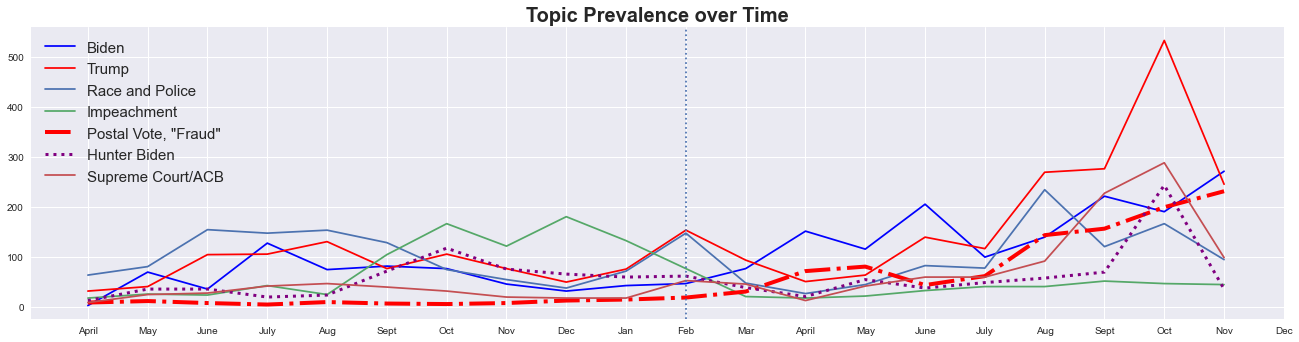

In [358]:
trump_df = df[df.nmf_label == 'trump']
trump_gb =trump_df.groupby([(trump_df.month_year.dt.year),(trump_df.month_year.dt.month)])['title'].count().to_frame()
trump_gb
count_trump = []
date_trump = []
for idx, val in enumerate(trump_gb.title):
    count_trump.append(val)
    date_trump.append(idx)

biden_df = df[df.nmf_label == 'biden']
biden_gb = biden_df.groupby([(biden_df.month_year.dt.year),(biden_df.month_year.dt.month)])['title'].count().to_frame()
count_biden = []
date_biden = []
for idx, val in enumerate(biden_gb.title):
    count_biden.append(val)
    date_biden.append(idx)

race_df = df[df.nmf_label == 'race_police']
race_gb = race_df.groupby([(race_df.month_year.dt.year),(race_df.month_year.dt.month)])['title'].count().to_frame()
count_race = []
date_race = []
for idx, val in enumerate(race_gb.title):
    count_race.append(val)
    date_race.append(idx)

harris_df = df[df.nmf_label == 'harris']
harris_gb = harris_df.groupby([(harris_df.month_year.dt.year),(harris_df.month_year.dt.month)])['title'].count().to_frame()
count_harris = []
date_harris = []
for idx, val in enumerate(harris_gb.title):
    count_harris.append(val)
    date_harris.append(idx)

dems_df = df[df.nmf_label == 'sand_warr_butti']
dems_gb = dems_df.groupby([(dems_df.month_year.dt.year),(dems_df.month_year.dt.month)])['title'].count().to_frame()
count_dems = []
date_dems = []
for idx, val in enumerate(dems_gb.title):
    count_dems.append(val)
    date_dems.append(idx)

immi_df = df[df.nmf_label == 'immi']
immi_gb = immi_df.groupby([(immi_df.month_year.dt.year),(immi_df.month_year.dt.month)])['title'].count().to_frame()
count_immi = []
date_immi = []
for idx, val in enumerate(immi_gb.title):
    count_immi.append(val)
    date_immi.append(idx)

imp_df = df[df.nmf_label == 'impeach']
imp_gb = imp_df.groupby([(imp_df.month_year.dt.year),(imp_df.month_year.dt.month)])['title'].count().to_frame()
count_imp = []
date_imp = []
for idx, val in enumerate(imp_gb.title):
    count_imp.append(val)
    date_imp.append(idx)

mail_df = df[df.nmf_label == 'mail_vote']
mail_gb = mail_df.groupby([(mail_df.month_year.dt.year),(mail_df.month_year.dt.month)])['title'].count().to_frame()
count_mail = []
date_mail = []
for idx, val in enumerate(mail_gb.title):
    count_mail.append(val)
    date_mail.append(idx)

hunt_df = df[df.nmf_label == 'hunter']
hunt_gb = hunt_df.groupby([(hunt_df.month_year.dt.year),(hunt_df.month_year.dt.month)])['title'].count().to_frame()
count_hunt = []
date_hunt = []
for idx, val in enumerate(hunt_gb.title):
    count_hunt.append(val)
    date_hunt.append(idx)

scotus_df = df[df.nmf_label == 'scotus']
scotus_gb = scotus_df.groupby([(scotus_df.month_year.dt.year),(scotus_df.month_year.dt.month)])['title'].count().to_frame()
count_scotus = []
date_scotus = []
for idx, val in enumerate(scotus_gb.title):
    count_scotus.append(val)
    date_scotus.append(idx)

plt.style.use('seaborn')
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'b')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'r')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg')
plt.plot(date_race, count_race, label = 'Race and Police')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', linestyle = '-.', c = 'r', lw = 4)
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', linestyle =':', c = 'purple', lw = 3)
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Topic Prevalence over Time", size = 20, weight = "bold")
plt.axvline(10, ls = ':')


plt.legend(fontsize = 15)

### Just Mail Fraud 

This is the most interesting finding, in my opinion. The President (at the time of writing, Nov. 15, 2020) continues to rail against the results of the election by claiming fraud in re: mail vote. The proximate advisors to the Trumpiverse at Breitbart had begun to make these claims all the way back in April. Of course this is some editorializing, but the seeds seem to have been sown to build this 'failsafe' argument early. This is seen clearly in the following TS. 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


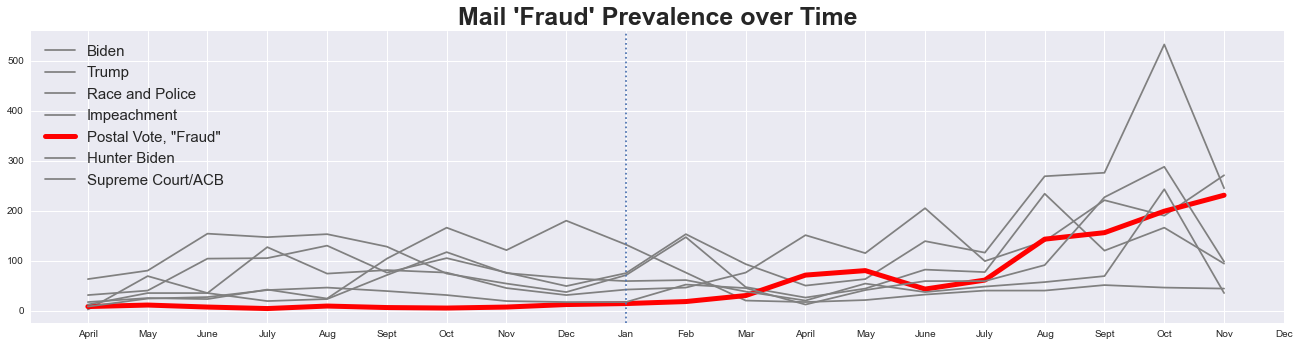

In [370]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'grey')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'r', lw = 5)
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'grey')
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Mail 'Fraud' Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

### Just Race

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


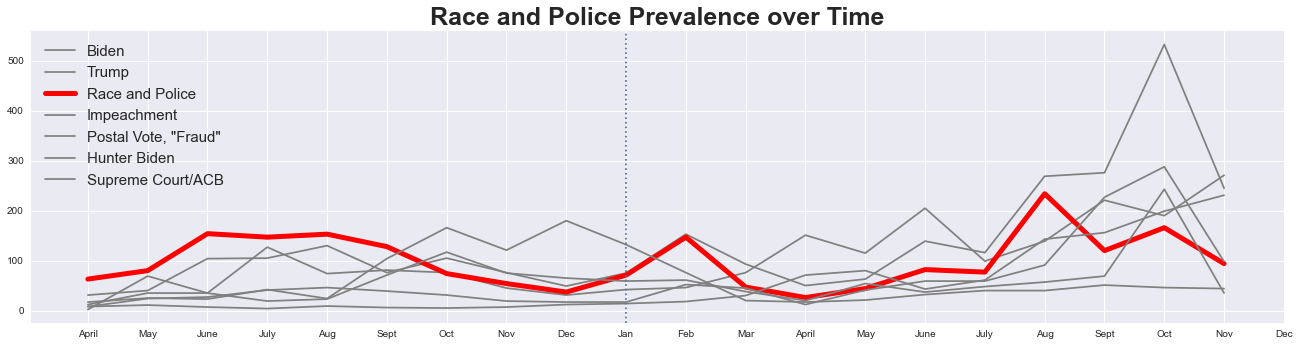

In [393]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'grey')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg', c = 'grey')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'r', lw = 5)
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'grey')
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Race and Police Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


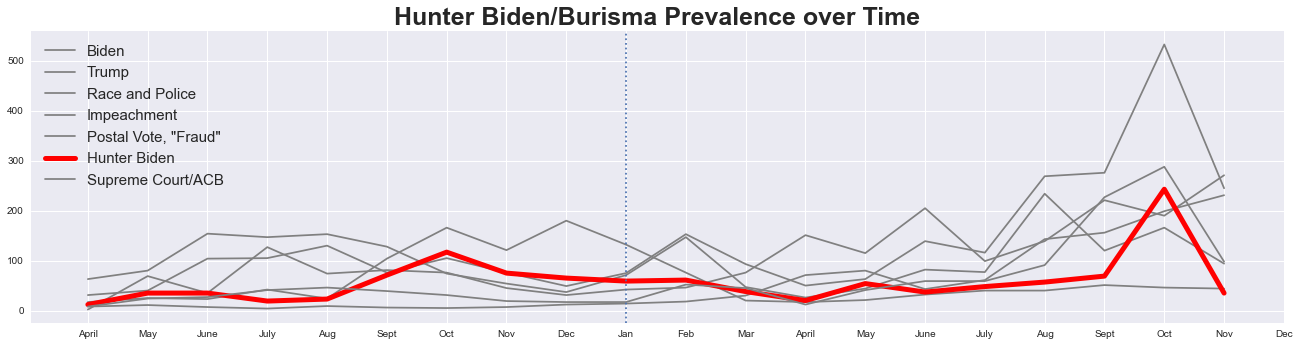

In [394]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'grey')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg', c = 'grey')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'r', lw = 5)
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Hunter Biden/Burisma Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


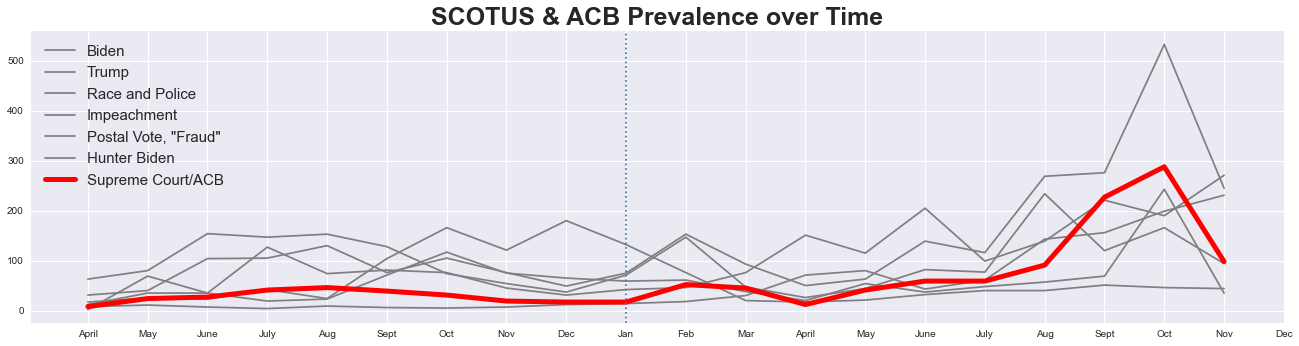

In [397]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'grey')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg', c = 'grey')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'grey')
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'r', lw = 5)

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("SCOTUS & ACB Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


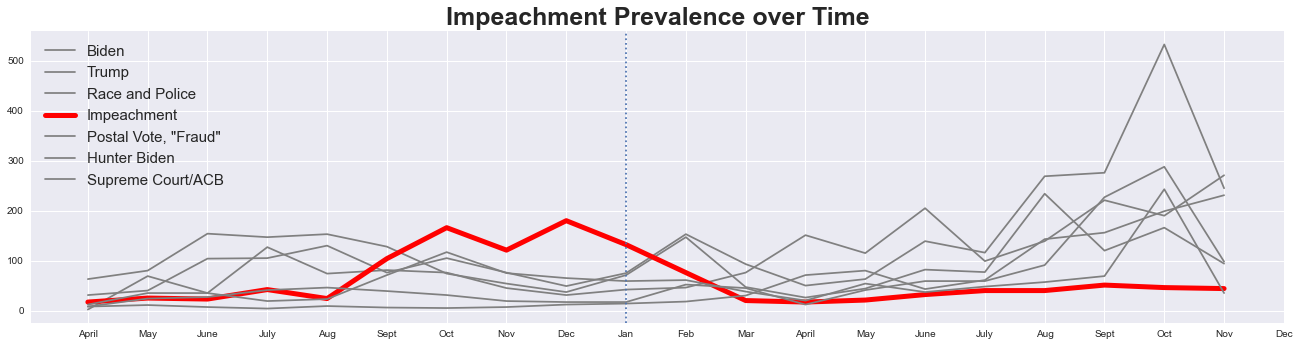

In [398]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'grey')
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
#plt.plot(date_dems, count_dems, label = 'Sanders/Warren/Buttigieg', c = 'grey')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'r', lw = 5)
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'grey')
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Impeachment Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


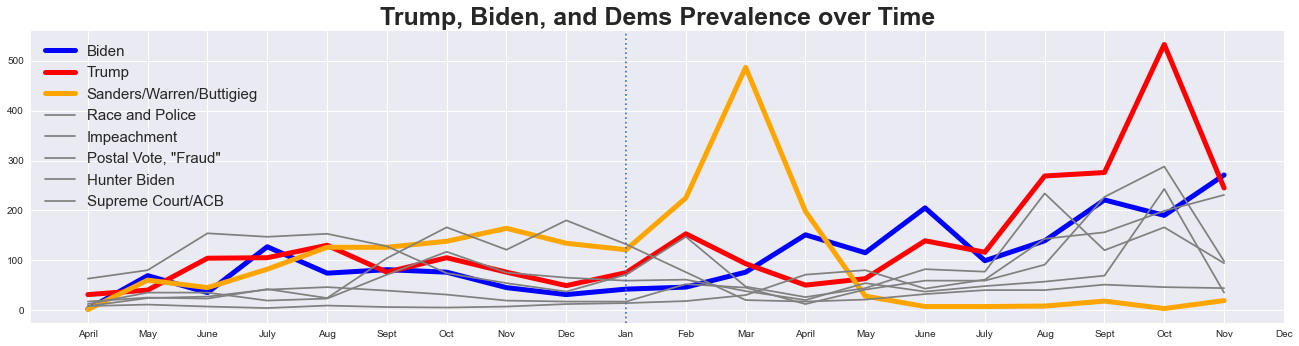

In [403]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'blue', lw = 5)
plt.plot(date_trump, count_trump, label = 'Trump', c = 'r', lw= 5)
#plt.plot(date_harris, count_harris, label = 'Harris')
plt.plot(date_dems[:len(date_biden)-1], count_dems[:len(date_biden)-1], label = 'Sanders/Warren/Buttigieg', c = 'orange', lw = 5)
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'grey')
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Trump, Biden, and Dems Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


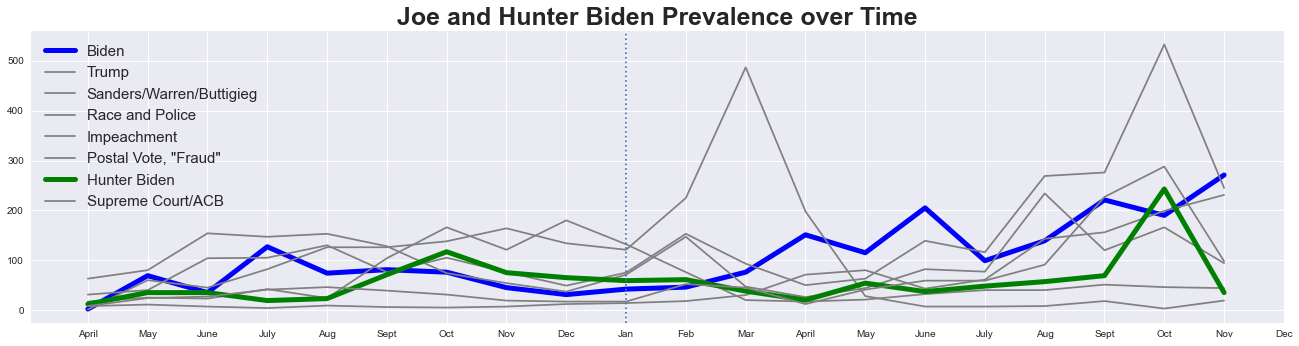

In [405]:
plt.figure(figsize=(20,5))
plt.plot(date_biden[:len(date_biden)-1], count_biden[:len(count_biden)-1], label = 'Biden', c = 'blue', lw = 5)
plt.plot(date_trump, count_trump, label = 'Trump', c = 'grey')
#plt.plot(date_harris, count_harris, label = 'Harris')
plt.plot(date_dems[:len(date_biden)-1], count_dems[:len(date_biden)-1], label = 'Sanders/Warren/Buttigieg', c = 'grey')
plt.plot(date_race, count_race, label = 'Race and Police', c = 'grey')
#plt.plot(date_immi, count_immi, label = 'Immigration')
plt.plot(date_imp, count_imp, label = 'Impeachment', c = 'grey')
plt.plot(date_mail, count_mail, label = 'Postal Vote, "Fraud"', c = 'grey')
plt.plot(date_hunt, count_hunt, label = 'Hunter Biden', c = 'green', lw = 5)
plt.plot(date_scotus, count_scotus, label = 'Supreme Court/ACB', c = 'grey')

x_labels = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar','April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 21, step=1), labels = x_labels)
plt.title("Joe and Hunter Biden Prevalence over Time", size = 25, weight = "bold")
plt.axvline(9, ls = ':')


plt.legend(fontsize = 15)

In [388]:
fraud = df[(df.nmf_label == 'mail_vote') & (df.month_year >= '2020-04')]
fraud

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dt         date  \
15    2020-11-10 16:21:38+00:00  10 Nov 2020   
17    2020-11-10 16:03:44+00:00  10 Nov 2020   
18    2020-11-10 15:33:34+00:00  10 Nov 2020   
23    2020-11-10 14:22:11+00:00  10 Nov 2020   
24    2020-11-10 14:07:49+00:00  10 Nov 2020   
...                         ...          ...   
7521  2020-04-01 21:44:55+00:00   1 Apr 2020   
7523  2020-04-01 14:15:55+00:00   1 Apr 2020   
7524  2020-04-01 13:09:12+00:00   1 Apr 2020   
7526  2020-04-01 10:40:30+00:00   1 Apr 2020   
7528  2020-04-01 09:46:25+00:00   1 Apr 2020   

                                                  title         author  \
15    Pennsylvania Auditors Warned of Dead People, D...    John Binder   
17    Georgia’s GOP Congressional Reps Demand Answer...  Joshua Caplan   
18    Democrats Suggest Out-of-State Liberals Move t...    John Binder   
23    Texas Lt. Gov. Dan Patrick Offers $1M Reward f...    Kyle Morris   
24    West Virginia AG Backs States Seeking to Inter...  Joshua Caplan   
...                                                 ...            ...   
7521  Survey: Two-Thirds Don’t ‘Feel Comfortable’ Go...       Tony Lee   
7523  Bernie Sanders Calls on Wisconsin to Delay Apr...   Hannah Bleau   
7524  Jennifer Lawrence Uses Coronavirus PSA to Push...  Jerome Hudson   
7526  Stacey Abrams: Vote-by-Mail Is ‘Safest Way to ...  Joshua Caplan   
7528  Alyssa Milano Joins Dems Increasing Call for M...   Hannah Bleau   

                                                article  \
15     Pennsylvania auditors alerted officials of po...   
17     Members of the U.S. House of Representatives ...   
18     Democrats are suggesting that out-of-state De...   
23     Texas Lt. Governor Dan Patrick announced Tues...   
24     West Virginia Attorney General Patrick Morris...   
...                                                 ...   
7521   Nearly two-thirds (66%) of Americans would no...   
7523   Sen. Bernie Sanders (I-VT) on Wednesday forma...   
7524   Actress Jennifer Lawrence is the latest Holly...   
7526   Appearing Wednesday on MSNBC Live, failed Geo...   
7528   Actress-turned-activist Alyssa Milano has joi...   

                                              trunc_art  \
15    Pennsylvania auditors alerted officials of pos...   
17    Members of the U.S. House of Representatives C...   
18    Democrats are suggesting that out-of-state Dem...   
23    Texas Lt. Governor Dan Patrick announced Tuesd...   
24    West Virginia Attorney General Patrick Morrise...   
...                                                 ...   
7521  Nearly two-thirds (66%) of Americans would not...   
7523  Sen. Bernie Sanders (I-VT) on Wednesday formal...   
7524  Actress Jennifer Lawrence is the latest Hollyw...   
7526  Appearing Wednesday on MSNBC Live, failed Geor...   
7528  Actress-turned-activist Alyssa Milano has join...   

                                              sentiment     sents  nmf_label  \
15    [{'label': 'NEGATIVE', 'score': 0.998977005481...  NEGATIVE  mail_vote   
17    [{'label': 'NEGATIVE', 'score': 0.930186927318...  NEGATIVE  mail_vote   
18    [{'label': 'NEGATIVE', 'score': 0.994661152362...  NEGATIVE  mail_vote   
23    [{'label': 'POSITIVE', 'score': 0.570901155471...  POSITIVE  mail_vote   
24    [{'label': 'POSITIVE', 'score': 0.995695054531...  POSITIVE  mail_vote   
...                                                 ...       ...        ...   
7521  [{'label': 'NEGATIVE', 'score': 0.974897265434...  NEGATIVE  mail_vote   
7523  [{'label': 'NEGATIVE', 'score': 0.508592188358...  NEGATIVE  mail_vote   
7524  [{'label': 'NEGATIVE', 'score': 0.896776020526...  NEGATIVE  mail_vote   
7526  [{'label': 'NEGATIVE', 'score': 0.992490887641...  NEGATIVE  mail_vote   
7528  [{'label': 'NEGATIVE', 'score': 0.819215953350...  NEGATIVE  mail_vote   

     month_year  neg  
15      2020-11    1  
17      2020-11    1  
18      2020-11    1  
23      2020-11    0  
24      2020-11    0  
...         ...  ...  
7521    2020-04    1  


In [245]:
plt.plot(trump_gb.index, trump_gb.title)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: setting an array element with a sequence.

In [222]:
trump = df[['month_year', 'nmf_label']].loc[df[df.nmf_label == 'trump'].index, ].groupby(df.month_year.dt.month).nmf_label.count()
trump 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month_year
1      75
2     153
3      93
4      81
5     103
6     243
7     221
8     399
9     352
10    638
11    321
12     49
Name: nmf_label, dtype: int64

In [201]:
nmf_df = df.groupby(['month_year'])['nmf_label'].agg(pd.Series.mode).to_frame()
nmf_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


nmf_label
month_year                 
2019-03               biden
2019-04               biden
2019-05         race_police
2019-06         race_police
2019-07         race_police
2019-08         race_police
2019-09     sand_warr_butti
2019-10             impeach
2019-11     sand_warr_butti
2019-12             impeach
2020-01     sand_warr_butti
2020-02     sand_warr_butti
2020-03     sand_warr_butti
2020-04               biden
2020-05               biden
2020-06               trump
2020-07               biden
2020-08               trump
2020-09               trump
2020-10               trump
2020-11               trump

In [211]:
df.article[15246]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'democrats taking part in the heartland forum event in storm lake  iowa  over the weekend weighed in on a woman’s allegations that former vice president joe biden acted inappropriately in an encounter in   when she was a candidate for nevada’s lieutenant governor  “i believe lucy flores ” sen  elizabeth warren  d ma  said    “and joe biden needs to answer for it ” warren said in a desmoines register article  flores wrote an essay about her experience with biden in new york magazine’s\xa0“the cut” last week where she recalled when she was a   year old candidate for state office and was backstage at an event with biden  flores wrote  in part   as i was taking deep breaths and preparing myself to make my case to the crowd  i felt two hands on my shoulders  i froze  “why is the vice president of the united states touching me ” i felt him get closer to me from behind  he leaned further in and inhaled my hair  i was mortified  i thought to myself  “i didn’t wash my hair today and the vice pr

In [163]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
X = dtm_tf
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(X)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeans(n_clusters=10)

In [166]:
inertias = []

for k_ in np.arange(1, 30):
    km = KMeans(n_clusters=k_)
    km.fit(X)
    inertias.append(km.inertia_)
inertias

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[10503942.858548116,
 9480749.70553885,
 9143026.869015615,
 8957811.274557497,
 8781489.051614944,
 8689049.123984803,
 8559820.629047988,
 8441844.497868177,
 8360038.400790647,
 8302876.455098368,
 8257061.068110235,
 8168830.858557876,
 8060948.110446423,
 8050536.442521458,
 8005623.268506965,
 7985385.954347822,
 7884749.806025663,
 7906489.379911091,
 7788498.131858429,
 7760274.761794767,
 7753599.962559178,
 7695230.227233749,
 7676430.67945653,
 7672889.109844792,
 7600033.279458265,
 7584058.584672813,
 7554401.690546037,
 7551250.29927406,
 7489228.518409574]

In [167]:
plt.plot(np.arange(1, 10), inertias, marker='o')
#plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: x and y must have same first dimension, but have shapes (9,) and (29,)

### Breakout CSV's by event
I created some sub-dfs from the main csv based on events like the nomination of Kamala Harris. 

In [78]:
kamala = df[df.dt >= "2020-08-11"]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
kamala.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5085 entries, 0 to 5084
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dt         5085 non-null   object
 1   date       5085 non-null   object
 2   title      5085 non-null   object
 3   author     5085 non-null   object
 4   article    5085 non-null   object
 5   no_sw      5085 non-null   object
 6   spacy_doc  5085 non-null   object
dtypes: object(7)
memory usage: 477.8+ KB
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
bk  = df[df.dt < "2020-08-11"]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
bk.to_csv('before_kamala.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
gf = df[df.dt >= "2020-05-26"]

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
gf.to_csv('since_gf.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = stop_ws,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.8, 
                                min_df = 0.01)
dtm_tfBK = tf_vectorizer.fit_transform(bk.article)
print(dtm_tfBK.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(10449, 3071)


In [113]:
lda_tfBK = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(dtm_tfBK)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tfBK, tf_vectorizer, mds = 'mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.062855  0.075661       1        1  15.991516
3      0.048513  0.244766       2        1  13.505151
7     -0.029886 -0.011982       3        1  11.647788
9     -0.052037  0.147951       4        1  10.166223
2      0.052347 -0.220784       5        1  10.015861
4     -0.176863  0.089845       6        1   9.813394
8     -0.085091 -0.171245       7        1   9.193948
6     -0.188146 -0.067039       8        1   7.127532
0      0.103146 -0.066507       9        1   7.089547
5      0.265163 -0.020665      10        1   5.449040, topic_info=             Term          Freq         Total Category  logprob  loglift
2845        trump  35003.000000  35003.000000  Default  30.0000  30.0000
310         biden  26610.000000  26610.000000  Default  29.0000  29.0000
1377  impeachment   5891.000000   5891.000000  Default  28.0000  28.0000
2427      sanders  11679.000000  11679.000000  Default  27.0000  27.0000
1333        house   8064.000000   8064.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1491         john    591.200821   2406.671168  Topic10  -5.2832   1.5059
470      children    502.949368   1343.973506  Topic10  -5.4448   1.9268
757     democrats    684.735210  10715.394619  Topic10  -5.1363   0.1593
1833          new    618.429386   9999.373574  Topic10  -5.2381   0.1266
2104    president    582.875530  29482.363109  Topic10  -5.2973  -1.0138

[644 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         3  0.848104  abortion
5         4  0.009740  abortion
5         6  0.076531  abortion
5         7  0.059833  abortion
5         9  0.004174  abortion
...     ...       ...       ...
3064      6  0.059653      york
3064      7  0.039358      york
3064      8  0.219546      york
3064      9  0.065802      york
3064     10  0.044278      york

[3141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 8, 10, 3, 5, 9, 7, 1, 6])

In [6]:
%load_ext autoreload
%autoreload 2

In [8]:
from clustering_util import silhouette_plots, plot_dendrogram

In [80]:
df[(df['dt'] > "2019-04-30")].tail(50)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dt         date  \
15259  2019-05-03 15:47:32+00:00   3 May 2019   
15260  2019-05-03 12:52:21+00:00   3 May 2019   
15261  2019-05-03 09:00:09+00:00   3 May 2019   
15262  2019-05-03 07:14:18+00:00   3 May 2019   
15263  2019-05-03 06:30:33+00:00   3 May 2019   
15264  2019-05-03 05:03:51+00:00   3 May 2019   
15265  2019-05-02 22:41:51+00:00   2 May 2019   
15266  2019-05-02 18:58:16+00:00   2 May 2019   
15267  2019-05-02 18:51:39+00:00   2 May 2019   
15268  2019-05-02 18:32:14+00:00   2 May 2019   
15269  2019-05-02 17:33:38+00:00   2 May 2019   
15270  2019-05-02 15:55:11+00:00   2 May 2019   
15271  2019-05-02 13:51:42+00:00   2 May 2019   
15272  2019-05-02 11:29:04+00:00   2 May 2019   
15273  2019-05-02 09:22:42+00:00   2 May 2019   
15274  2019-05-02 09:20:58+00:00   2 May 2019   
15275  2019-05-02 08:04:47+00:00   2 May 2019   
15276  2019-05-02 07:53:42+00:00   2 May 2019   
15277  2019-05-02 07:29:38+00:00   2 May 2019   
15278  2019-05-02 06:43:21+00:00   2 May 2019   
15279  2019-05-02 06:35:45+00:00   2 May 2019   
15280  2019-05-02 05:54:34+00:00   2 May 2019   
15281  2019-05-01 19:59:28+00:00   1 May 2019   
15282  2019-05-01 19:51:00+00:00   1 May 2019   
15283  2019-05-01 17:32:54+00:00   1 May 2019   
15284  2019-05-01 17:21:14+00:00   1 May 2019   
15285  2019-05-01 17:18:18+00:00   1 May 2019   
15286  2019-05-01 16:59:31+00:00   1 May 2019   
15287  2019-05-01 14:59:58+00:00   1 May 2019   
15288  2019-05-01 12:33:54+00:00   1 May 2019   
15289  2019-05-01 10:20:59+00:00   1 May 2019   
15290  2019-05-01 08:47:32+00:00   1 May 2019   
15291  2019-05-01 08:36:22+00:00   1 May 2019   
15292  2019-04-30 19:35:12+00:00  30 Apr 2019   
15293  2019-04-30 15:26:21+00:00  30 Apr 2019   
15294  2019-04-30 14:44:12+00:00  30 Apr 2019   
15295  2019-04-30 14:43:00+00:00  30 Apr 2019   
15296  2019-04-30 14:37:10+00:00  30 Apr 2019   
15297  2019-04-30 12:56:29+00:00  30 Apr 2019   
15298  2019-04-30 12:36:23+00:00  30 Apr 2019   
15299  2019-04-30 10:38:26+00:00  30 Apr 2019   
15300  2019-04-30 09:51:13+00:00  30 Apr 2019   
15301  2019-04-30 08:10:25+00:00  30 Apr 2019   
15302  2019-04-30 07:49:38+00:00  30 Apr 2019   
15303  2019-04-30 06:37:35+00:00  30 Apr 2019   
15304  2019-04-30 06:10:38+00:00  30 Apr 2019   
15305  2019-04-30 05:45:52+00:00  30 Apr 2019   
15306  2019-04-30 05:26:34+00:00  30 Apr 2019   
15307  2019-04-30 05:12:09+00:00  30 Apr 2019   
15308  2019-04-30 04:52:39+00:00  30 Apr 2019   

                                                   title  \
15259  Joe Biden Gains 23 Endorsements from Florida L...   
15260  Castro: Trump Is Celebrating in the End Zone b...   
15261  Buttigieg on Impeachment: ‘Grotesque’ Trump Sh...   
15262  Joe Biden Brags About Women of Color Learning ...   
15263        Dem Rep. Moulton Calls for Barr Impeachment   
15264  Joe Biden Borrowing Sherrod Brown’s Message Ab...   
15265  Schweizer: The Left Is Just Attacking Me and t...   
15266  Poll: Plurality of Minority Voters Say ‘Too Ea...   
15267  Bernie: Trump ‘Cheerleader’ for ‘Military Indu...   
15268  Elizabeth Warren Doubles Down on ‘Racism’ of D...   
15269  Bokhari: Link-banning Is Facebook’s Terrifying...   
15270  Trump: ‘I’d Be Very Happy’ if Biden Was My Opp...   
15271  TIME: Buttigieg Could ‘Vanquish America’s Demons’   
15272  Bennet: ‘The Democratic Party Doesn’t Stand fo...   
15273  Donald Trump: Joe Biden Not ‘Radical Left’ Eno...   
15274  Rep. Bradley Byrne Condemns “Horrific” Abortio...   
15275  Watch Live: Pro-Trump Latino Group Holds Press...   
15276  NYT Confirms Hunter Biden Was Paid by Ukrainia...   
15277  Kamala Harris: Trump’s ‘Primary Interest Has B...   
15278  Stephen Colbert Mocks Joe Biden’s ‘Make Americ...   
15279  Michael Bennet Enters 2020 Race — ‘My Plan Is ...   
15280  Chris Matthews Apologizes to Kamala After Comp...   
15281  2020 Democratic Presidential Candidates Suppor...   
15282  Biden: Barr Should Resign, ‘He’s Lost the Conf...   
15283  Union Bosses Hope Ameri